In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

from nltk.corpus import stopwords
from tqdm import tqdm
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
# training/training_variants is a comma separated file containing the description of the genetic mutations used for training.
# Fields are :

# ID : the id of the row used to link the mutation to the clinical evidence <\br>
# Gene : the gene where this genetic mutation is located <\br>
# Variation : the aminoacid change for this mutations <\br>
# Class : 1-9 the class this genetic mutation has been classified on <\br>


data = pd.read_csv("../input/msk-redefining-cancer-treatment/training_variants.zip")
print("Number of data points : ", data.shape[0])
print("Number of features : ", data.shape[1])
print("Features : ", data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
data_text = pd.read_csv("../input/msk-redefining-cancer-treatment/training_text.zip", sep = "\|\|", engine = "python", names = ["ID", "Text"], skiprows=1)
print("Number of data points : ", data_text.shape[0])
print("Number of features : ", data_text.shape[1])
print("Features : ", data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# Merging both gene variation and text data based on "ID"

df = pd.merge(data, data_text, on = 'ID', how = 'left')
df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

We can see "Text" column has 5 missing values.

In [6]:
df[df.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [7]:
# Replacing NaN with Gene + Variation

df.loc[df['Text'].isnull(),'Text'] = df['Gene'] +' '+df['Variation']

In [8]:
df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         0
dtype: int64

In [9]:
# How it looks after replacing NaN with Gene+Variation ?

df[df['ID'] == 1277]

,ID,Gene,Variation,Class,Text
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


## Preprocessing of text

In [10]:
import nltk
nltk.download("stopwords")

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [11]:
stopwords = set(stopwords.words('english'))

def nlp_preprocessing(text):
    string = ""
    # replace every special char with space
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
    
    # replacing multiple spaces with single space
    text = re.sub('\s+', ' ', text)
    
    # Converting all the characters into lower-case
    text = text.lower()
    
    for word in text.split():
        # if the word is a not a stop word then retain that word from the data
        if word not in stopwords:
            string += word + " "
    return string

In [12]:
df['Text'] = df['Text'].progress_apply(nlp_preprocessing)

  0%|          | 0/3321 [00:00<?, ?it/s]

## Test, Train and Cross Validation Split


Splitting data into train, test and cross validation (64:20:16)

In [13]:
y_true = df.Class.values

# Replacing spaces between words by underscores as Gene and Variation name should occur as it is
df.Gene = df.Gene.str.replace("\s+", '_')  
df.Variation = df.Variation.replace("\s+", "_")



# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [14]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_val.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


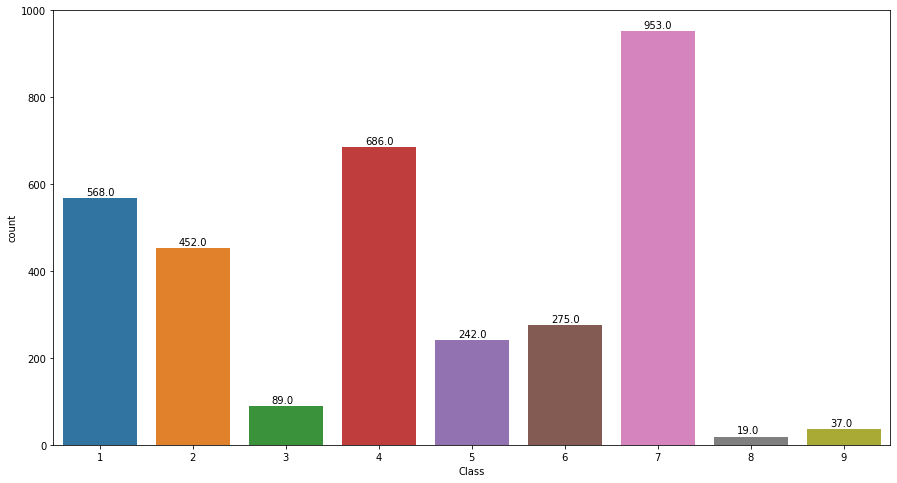

In [15]:
# Distribution of classes in the data
plt.figure(figsize=(15,8))
ax = sns.countplot(x = df['Class'])

for p in ax.patches: 
    ax.annotate('{:.1f}'.format(p.get_height().astype(int)), (p.get_x()+0.25, p.get_height()+7)) 
plt.show()

#  Prediction using a 'Random' Model

>In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    
    
    labels = [1,2, 3, 4, 5, 6, 7, 8, 9]
    # representing A in heatmap format
    #cmap=sns.light_palette("blue")
    #plt.subplot(1, 3, 1)
    plt.figure(figsize=(20,4))
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()
    
    #plt.subplot(1, 3, 2)
    plt.figure(figsize=(20,4))
    sns.heatmap(B, annot=True, cmap='Blues', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.show()
    
    #plt.subplot(1, 3, 3)
    plt.figure(figsize=(20,4))
    # representing B in heatmap format
    sns.heatmap(A, annot=True, vmin=0, vmax=0.5, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Cross Validation Data using Random Model 2.430390555761566


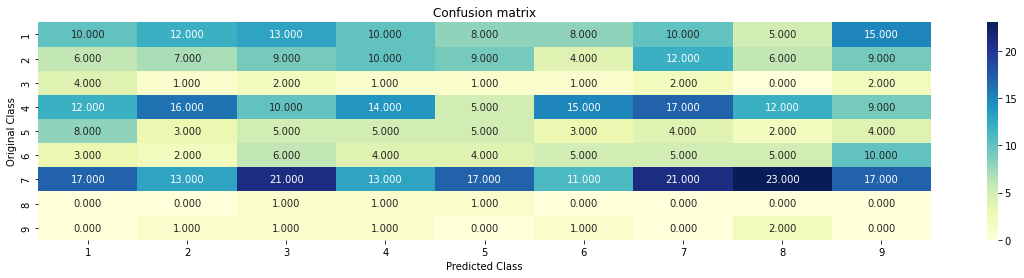

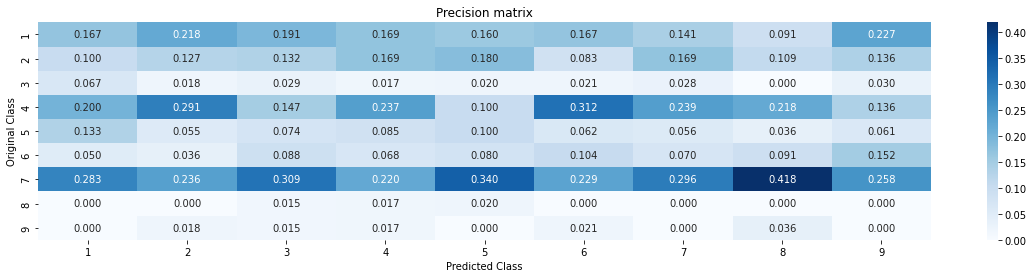

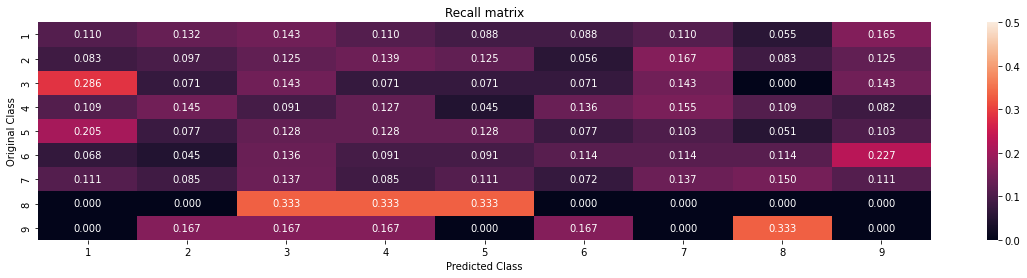

In [17]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

len_of_cv = X_val.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted = np.zeros((len_of_cv, 9))

for i in range(len_of_cv):
    rand_prob = np.random.rand(1,9)   # generating random numbers for all 9 classes
    cv_predicted[i] = ((rand_prob / sum(sum(rand_prob)))[0])  # As we are working with probabilities, sum of all probabilites should be 1.
    
cv_ypred = np.argmax(cv_predicted, axis = 1) + 1 # Storing index of max value. Adding 1 because index starts with 0 but our classes range from 1-9
print("Log loss on Cross Validation Data using Random Model",log_loss(X_val['Class'],cv_predicted, eps=1e-15))
plot_confusion_matrix(X_val['Class'], cv_ypred)

Log loss on Cross Validation Data using Random Model 2.428874742574655


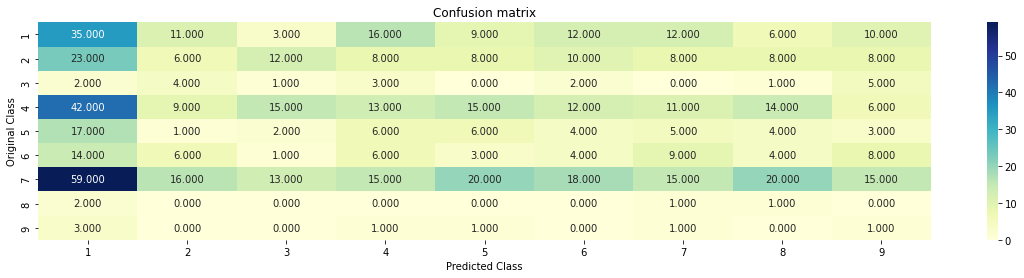

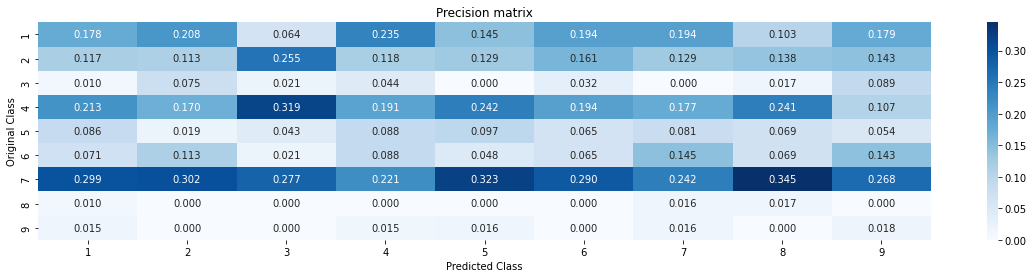

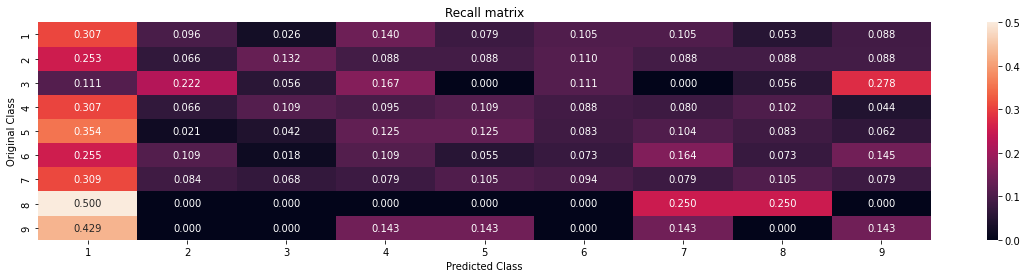

In [18]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

len_of_test = X_test.shape[0]

# we create a output array that has exactly same size as the "Test" data
xtest_predicted = np.zeros((len_of_test, 9))

for i in range(len_of_cv):
    rand_prob = np.random.rand(1,9)   # generating random numbers for all 9 classes
    xtest_predicted[i] = ((rand_prob / sum(sum(rand_prob)))[0])  # As we are working with probabilities, sum of all probabilites should be 1.
    
xtest_ypred = np.argmax(xtest_predicted, axis = 1) + 1 # Storing index of max value. Adding 1 because index starts with 0 but our classes range from 1-9
print("Log loss on Cross Validation Data using Random Model",log_loss(X_test['Class'],xtest_predicted, eps=1e-15))
plot_confusion_matrix(X_test['Class'], xtest_ypred)

## Univeriate Analysis

### Univariate Analysis on Gene Feature

Q1. Gene, What type of feature it is ?

Ans. Gene is a categorical variable

Q2. How many categories are there and How they are distributed?

In [19]:
unique_genes = df['Gene'].value_counts()
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the data, and they are distibuted as follows: ")
# the top 10 genes that occured most
print(unique_genes.head(10))

Ans: There are 264 different categories of genes in the data, and they are distibuted as follows: 
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64


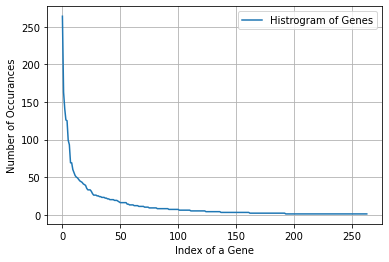

In [20]:
s = sum(unique_genes.values);
h = unique_genes.values
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

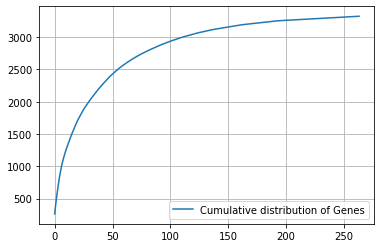

In [21]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Q3. How to featurize this Gene feature ?

Ans. There are two ways we can featurize this variable:

    1. One hot Encoding
    2. Response coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

### 1. One-Hot Encoding

In [22]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_val['Gene'])

In [23]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1b', 'arid2', 'arid5b', 'asxl1', 'atm', 'atrx',
       'aurka', 'aurkb', 'axin1', 'b2m', 'bap1', 'bard1', 'bcor', 'braf',
       'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11', 'carm1',
       'casp8', 'cbl', 'ccnd1', 'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4',
       'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b', 'chek2',
       'cic', 'crebbp', 'ctcf', 'ctla4', 'ctnnb1', 'ddr2', 'dicer1',
       'dnmt3a', 'dnmt3b', 'dusp4', 'egfr', 'eif1ax', 'elf3', 'ep300',
       'epas1', 'erbb2', 'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4',
       'erg', 'errfi1', 'esr1', 'etv1', 'etv6', 'ewsr1', 'ezh2', 'fanca',
       'fat1', 'fbxw7', 'fgf19', 'fgf3', 'fgf4', 'fgfr1', 'fgfr2',
       'fgfr3', 'fgfr4', 'flt1', 'flt3', 'foxa1', 'foxp1', 'fubp1',
       'gata3', 'gli1', 'gna11', 'gnaq', 'gnas', 'h3f3a', 'hla', 'hnf1a',
       'hras', 'idh1', 'idh2', 'igf1r', 'ikbke', 'ikzf1', 'il7r',
       '

In [24]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 229)


In [25]:
X_train['Gene'].value_counts()

BRCA1    160
TP53     101
EGFR      93
PTEN      86
BRCA2     68
        ... 
PAX8       1
AKT3       1
ASXL1      1
KDM5A      1
MDM4       1
Name: Gene, Length: 230, dtype: int64

In [26]:
df['Gene'].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: Gene, Length: 264, dtype: int64

In [27]:
len(set(df.Gene))

264

### 2. Below code performs Respose Coding using Laplace smoothing..

In [28]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        #print(i, denominator)
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in current class
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    
    
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    #print(gv_dict)
    # value_count is similar in get_gv_fea_dict
    value_count = df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [29]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_val))

In [30]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)
print("test_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", test_gene_feature_responseCoding.shape)
print("cv_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", cv_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)
test_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (665, 9)
cv_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (532, 9)


Q4. How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

### Gene feature (One-Hot Encoding)

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

For values of alpha =  1e-05 The log loss is: 1.2094567502570837
For values of alpha =  0.0001 The log loss is: 1.1819275112510295
For values of alpha =  0.001 The log loss is: 1.213506659239776
For values of alpha =  0.01 The log loss is: 1.3131969459394326
For values of alpha =  0.1 The log loss is: 1.3960795564401647
For values of alpha =  1 The log loss is: 1.4353686152904699


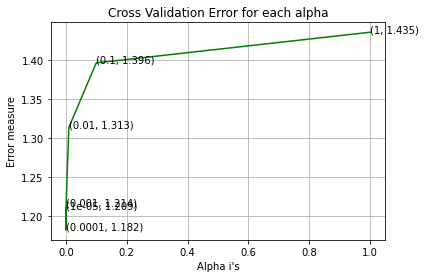

In [32]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels = clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [33]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9986983545923436
For values of best alpha =  0.0001 The cross validation log loss is: 1.1819275112510295
For values of best alpha =  0.0001 The test log loss is: 1.1629576594001312


Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

In [34]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_val[X_val['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_val.shape[0],":" ,(cv_coverage/X_val.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  264  genes in train dataset?
Ans
1. In test data 640 out of 665 : 96.2406015037594
2. In cross validation data 513 out of  532 : 96.42857142857143


### Gene Feature (ResponseCoding)

For values of alpha =  1e-05 The log loss is: 1.3396341344678726
For values of alpha =  0.0001 The log loss is: 1.3777001542443044
For values of alpha =  0.001 The log loss is: 1.4502065307173837
For values of alpha =  0.01 The log loss is: 1.4824247038162228
For values of alpha =  0.1 The log loss is: 1.490296723790576
For values of alpha =  1 The log loss is: 1.4916757865985881


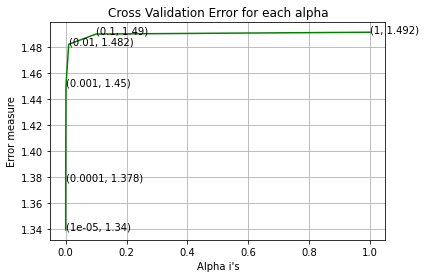

In [35]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 42)
    clf.fit(train_gene_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_gene_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels = clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [36]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_responseCoding, y_train)


predict_y = sig_clf.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1e-05 The train log loss is: 1.1891564484788195
For values of best alpha =  1e-05 The cross validation log loss is: 1.3396341344678726
For values of best alpha =  1e-05 The test log loss is: 1.2995621373645836


### 3.2.2 Univariate Analysis on Variation Feature
Q7. Variation, What type of feature is it ?

Ans. Variation is a categorical variable

Q8. How many categories are there?


In [37]:
unique_variations = X_train['Variation'].value_counts()
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)
# the top 10 variations that occured most
print(unique_variations.head(10))

Ans: There are 1933 different categories of variations in the train data, and they are distibuted as follows
Truncating Mutations    50
Deletion                49
Amplification           42
Fusions                 23
Overexpression           5
Q61R                     3
Q22K                     2
Q61H                     2
Q209L                    2
A146V                    2
Name: Variation, dtype: int64


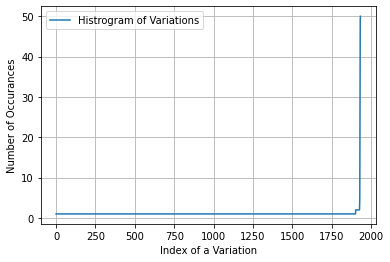

In [38]:
h = sorted(unique_variations.values)
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

It can seen that the plot is highly skewed. That means there are very few number of variation whose occurance is more than 5.

[4.70809793e-04 9.41619586e-04 1.41242938e-03 ... 9.53389831e-01
 9.76459510e-01 1.00000000e+00]


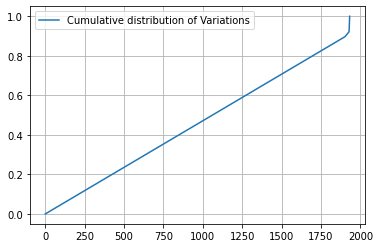

In [39]:
s = sum(unique_variations.values)
h = h/s
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Q9. How to featurize this Variation feature ?

Ans.There are two ways we can featurize this variable:

    1. One hot Encoding
    2. Response coding
We will be using both these methods to featurize the Variation Feature

In [40]:
# One-Hot Encoding of variation feature.

variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_val['Variation'])

In [41]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1975)


In [42]:
# Response Coding..........


# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_val))

In [43]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


Q10. How good is this Variation feature in predicting y_i?

Let's build a model just like the earlier!

### Variation Feature (One-Hot Encoding)

For values of alpha =  1e-05 The log loss is: 1.6815626593897215
For values of alpha =  0.0001 The log loss is: 1.6759164296960527
For values of alpha =  0.001 The log loss is: 1.6782914534982836
For values of alpha =  0.01 The log loss is: 1.6916341124799719
For values of alpha =  0.1 The log loss is: 1.7114310243469704
For values of alpha =  1 The log loss is: 1.7125958087747306


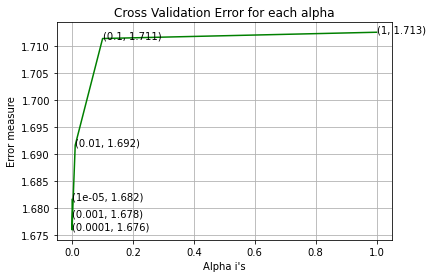

In [44]:
alpha = [10**x for x in range(-5,1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l2', loss = 'log', random_state=42, n_jobs = -1)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid", n_jobs = -1)
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels = clf.class_weight, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [45]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.7312761215213684
For values of best alpha =  0.0001 The cross validation log loss is: 1.6759164296960527
For values of best alpha =  0.0001 The test log loss is: 1.662755270813458


Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Not sure! But lets be very sure using the below analysis.

In [46]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_val[X_val['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_val.shape[0],":" ,(cv_coverage/X_val.shape[0])*100)

Q12. How many data points are covered by total  1933  genes in test and cross validation data sets?
Ans
1. In test data 73 out of 665 : 10.977443609022556
2. In cross validation data 55 out of  532 : 10.338345864661653


### Variation Feature (Response Coding)

For values of alpha =  1e-05 The log loss is: 0.40735069876241714
For values of alpha =  0.0001 The log loss is: 0.540028741503986
For values of alpha =  0.001 The log loss is: 0.6764994888627752
For values of alpha =  0.01 The log loss is: 0.7422111399961652
For values of alpha =  0.1 The log loss is: 0.7674062203392874
For values of alpha =  1 The log loss is: 0.8247964224380823


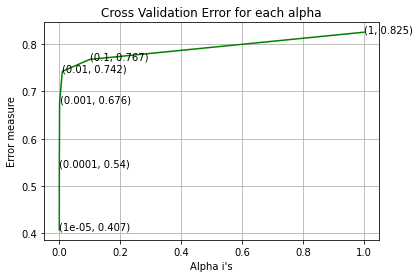

In [47]:
alpha = [10**x for x in range(-5,1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l2', loss = 'log', random_state=42, n_jobs = -1)
    clf.fit(train_variation_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid", n_jobs = -1)
    sig_clf.fit(train_variation_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels = clf.class_weight, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [48]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  1e-05 The train log loss is: 0.4211919458113838
For values of best alpha =  1e-05 The cross validation log loss is: 0.40735069876241714
For values of best alpha =  1e-05 The test log loss is: 0.36772327875305083


### 3.2.3 Univariate Analysis on Text Feature
1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [49]:
# One-Hot Encoding..........

# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['Text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53233


In [50]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

In [51]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [52]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(X_train)



confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)


In [53]:
confuse_array[0]

array([0.09772952, 0.04639684, 0.00691017, 0.23198421, 0.07847976,
       0.43089832, 0.0952616 , 0.00542942, 0.00691017])

In [54]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_val)

In [55]:
# we convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [56]:
train_text_feature_responseCoding

array([[0.2334128 , 0.10810886, 0.02473058, ..., 0.23070848, 0.01031799,
        0.01722741],
       [0.21306201, 0.11942111, 0.02608115, ..., 0.29401938, 0.01382883,
        0.02346009],
       [0.21970115, 0.0883241 , 0.02842103, ..., 0.21151089, 0.0081213 ,
        0.01380722],
       ...,
       [0.16317747, 0.18106492, 0.02639118, ..., 0.28623564, 0.01444953,
        0.02351488],
       [0.15199811, 0.10999579, 0.024657  , ..., 0.27197208, 0.01002458,
        0.0163598 ],
       [0.21496015, 0.09977541, 0.02704677, ..., 0.23354003, 0.00894082,
        0.01492609]])

In [57]:
len(train_text_feature_responseCoding.T)

9

In [58]:
len(train_text_feature_responseCoding.sum(axis=1))

2124

In [59]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['Text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_val['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [60]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [61]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5286, 4: 3369, 5: 2932, 6: 2791, 7: 2536, 9: 1860, 8: 1847, 10: 1535, 12: 1234, 11: 995, 14: 963, 15: 921, 16: 814, 13: 762, 18: 692, 20: 657, 19: 597, 17: 546, 21: 538, 24: 519, 22: 512, 23: 418, 34: 417, 25: 380, 30: 359, 27: 358, 29: 335, 26: 329, 28: 313, 36: 312, 47: 284, 32: 279, 31: 264, 35: 262, 33: 237, 40: 225, 42: 223, 39: 222, 45: 200, 38: 200, 37: 196, 50: 193, 41: 191, 43: 188, 48: 186, 44: 186, 46: 174, 49: 163, 54: 161, 57: 149, 52: 147, 60: 146, 51: 144, 55: 140, 56: 134, 64: 133, 58: 120, 68: 119, 63: 116, 59: 116, 65: 114, 67: 111, 62: 109, 53: 107, 71: 101, 70: 99, 66: 98, 61: 98, 72: 97, 86: 96, 74: 90, 73: 90, 84: 85, 77: 85, 88: 76, 78: 75, 80: 74, 69: 72, 75: 70, 96: 68, 87: 68, 76: 68, 91: 67, 94: 66, 83: 66, 82: 66, 81: 66, 105: 65, 102: 65, 85: 63, 95: 61, 92: 60, 98: 59, 99: 58, 97: 58, 90: 58, 89: 57, 101: 56, 136: 55, 103: 54, 79: 54, 104: 52, 108: 51, 100: 51, 115: 50, 106: 50, 129: 49, 112: 49, 138: 47, 116: 47, 144: 45, 124: 45, 114: 44, 137

For values of alpha =  1e-05 The log loss is: 1.3072791700275055
For values of alpha =  0.0001 The log loss is: 1.1729958685872535
For values of alpha =  0.001 The log loss is: 1.1826334934076665
For values of alpha =  0.01 The log loss is: 1.3146299324826671
For values of alpha =  0.1 The log loss is: 1.388234217880709
For values of alpha =  1 The log loss is: 1.6056389826831523


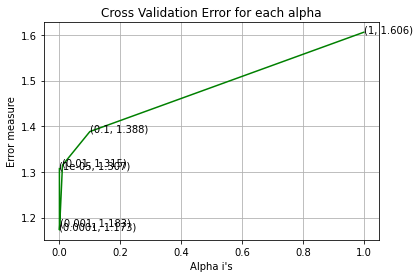

In [62]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i, n_jobs = -1)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels= clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [63]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6790026610031683
For values of best alpha =  0.0001 The cross validation log loss is: 1.1760771167005393
For values of best alpha =  0.0001 The test log loss is: 1.0925241774064613


Q. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it seems like!

In [64]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2


len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(X_val)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.505 % of word of test data appeared in train data
97.937 % of word of Cross Validation appeared in train data


# 4. Machine Learning Models

In [65]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y - test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [66]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [67]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [68]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_val['Class']))

In [69]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55437)
(number of data points * number of features) in test data =  (665, 55437)
(number of data points * number of features) in cross validation data = (532, 55437)


In [70]:
## Response Coding.........

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [71]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## 4.1. Base Line Model

### 4.1.1. Naive Bayes

for alpha = 1e-05
Log Loss : 1.2694144395959106
for alpha = 0.0001
Log Loss : 1.2611374897610104
for alpha = 0.001
Log Loss : 1.2623341213480912
for alpha = 0.1
Log Loss : 1.242539988425283
for alpha = 1
Log Loss : 1.2721239043252164
for alpha = 10
Log Loss : 1.383608678221858
for alpha = 100
Log Loss : 1.4263875180289152
for alpha = 1000
Log Loss : 1.3298131374936901


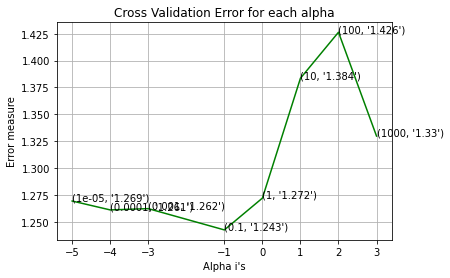

In [72]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_val, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [73]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.8688709118975793
For values of best alpha =  0.1 The cross validation log loss is: 1.242539988425283
For values of best alpha =  0.1 The test log loss is: 1.2093844752912144


4.1.1.2. Testing the model with best hyper paramters

Log Loss : 1.242539988425283
Number of missclassified point : 0.38533834586466165


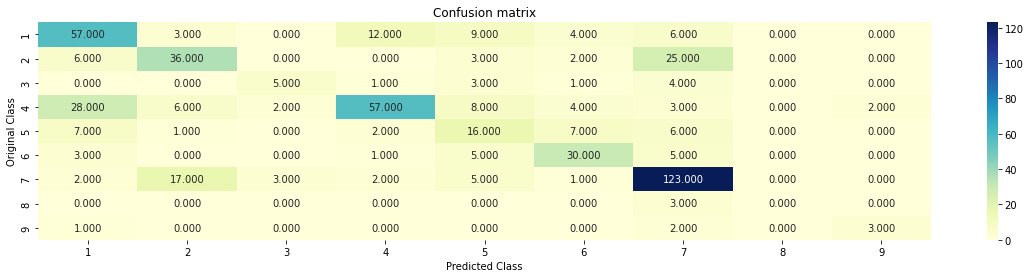

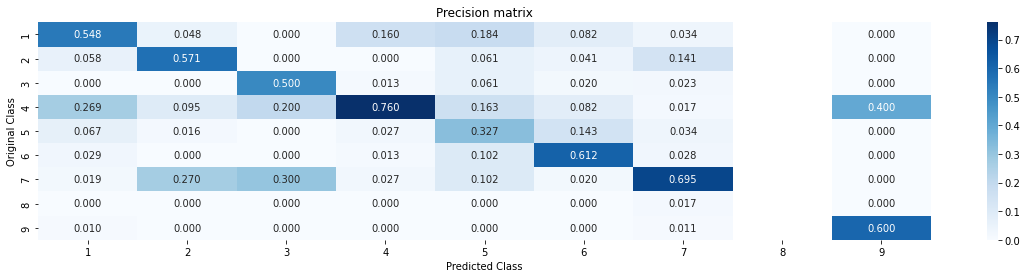

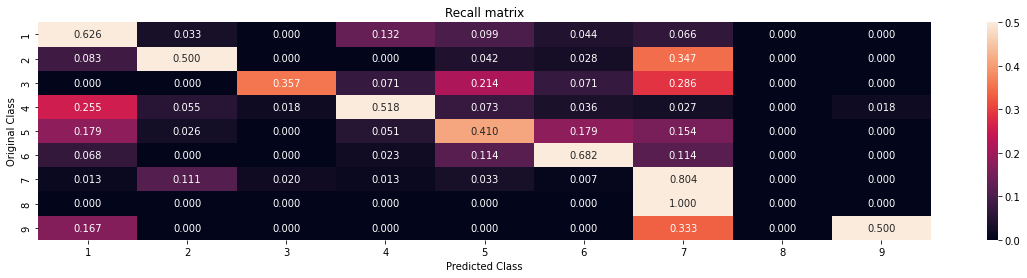

In [74]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_val, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- y_val))/y_val.shape[0])
plot_confusion_matrix(y_val, sig_clf.predict(cv_x_onehotCoding.toarray()))

4.1.1.3. Feature Importance, Correctly classified point

In [75]:
test_point_index = 10
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0789 0.0726 0.0139 0.1014 0.036  0.0333 0.6546 0.0048 0.0046]]
Actual Class : 7
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
17 Text feature [activating] present in test data point [True]
18 Text feature [downstream] present in test data point [True]
19 Text feature [presence] present in test data point [True]
20 Text feature [inhibitor] present in test data point [True]
21 Text feature [well] present in test data point [True]
22 Text feature [potential] present in test data point [True]
23 Text feature [showed] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [previously] present in test data point [True]
26 Text feature [recently] present in test data point [True]
28 Text feature [factor] present in test data point [True]
29 Text feature [obtained] present in test data point [True]
30 Text feature [expres

In [76]:
X_test['Text'].iloc[test_point_index]

'report preclinical evaluation pf 06463922 potent brain penetrant alk ros1 inhibitor compared clinically available alk inhibitors pf 06463922 displayed superior potency known clinically acquired alk mutations including highly resistant g1202r mutant furthermore pf 06463922 treatment led regression eml4 alk driven brain metastases leading prolonged mouse survival superior manner finally pf 06463922 demonstrated high selectivity safety margins variety preclinical studies results suggest pf 06463922 highly effective treatment patients alk driven lung cancers including relapsed clinically available alk inhibitors due secondary alk kinase domain mutations due failed control brain metastases go introduction clinical success targeting oncogenic tyrosine kinases genetically altered activating mutations gene translocations gene amplification launched new era cancer therapy weinstein 2002 however acquired resistance major limitation efficacy tyrosine kinase inhibitors tkis clinic bagrodia et al 

In [77]:
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
indices[0]

array([27718, 15108, 40487, 15104, 15101, 40489, 40493, 15111, 15092,
       40506, 40526, 40530, 15075, 40546, 40549, 15091, 40551, 15113,
       40476, 15146, 40440, 15143, 40446, 40448, 40450, 15114, 40452,
       40455, 15126, 40457, 15122, 15119, 40474, 40454, 15148, 40555,
       15058, 40608, 15022, 40613, 15019, 40624, 40630, 15027, 15006,
       15002, 40651, 40655, 14996, 40661, 40662, 40648, 40562, 40607,
       15031, 40574, 40576, 40586, 40587, 15047, 15046, 40606, 40588,
       15038, 40595, 40599, 40602, 40604, 15032, 40592, 40669, 40437,
       40434, 40358, 15233, 40362, 40363, 40367, 15223, 15237, 15222,
       40375, 40379, 40380, 40381, 15210, 40382, 40368, 15208, 15239,
       15241, 40331, 40335, 40338, 40339, 15262, 15259, 15240, 15257,
       15255])

In [78]:
for i in range(2):
    test_point_index = np.random.randint(0, len(X_test))
    no_feature = 100
    predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
    print("Index : ", test_point_index)
    print("Predicted Class :", predicted_cls[0])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
    print("Actual Class :", y_test[test_point_index])
    indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
    print("-"*50)
    get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)


Index :  257
Predicted Class : 7
Predicted Class Probabilities: [[0.0789 0.0726 0.0139 0.1014 0.036  0.0333 0.6546 0.0048 0.0046]]
Actual Class : 7
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
17 Text feature [activating] present in test data point [True]
18 Text feature [downstream] present in test data point [True]
19 Text feature [presence] present in test data point [True]
21 Text feature [well] present in test data point [True]
22 Text feature [potential] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [previously] present in test data point [True]
26 Text feature [recently] present in test data point [True]
28 Text feature [factor] present in test data point [True]
29 Text feature [obtained] present in test data point [True]
31 Text feature [growth] present in test data point [True]
32 Text feature [activation] present in test data point [True]
33 Text f

## 4.2. K Nearest Neighbour Classification

>4.2.1. Hyper parameter tuning

In [79]:
from sklearn.neighbors import KNeighborsClassifier

for alpha = 2
Log Loss : 0.9275143038713757
for alpha = 3
Log Loss : 0.8970191762375946
for alpha = 5
Log Loss : 0.8820858268983708
for alpha = 11
Log Loss : 0.917787197215861
for alpha = 15
Log Loss : 0.9321138389620051
for alpha = 21
Log Loss : 0.9535562637372423
for alpha = 31
Log Loss : 0.9398779487178511
for alpha = 41
Log Loss : 0.9420547237944568
for alpha = 51
Log Loss : 0.9519799609396038
for alpha = 99
Log Loss : 1.0131220887220447


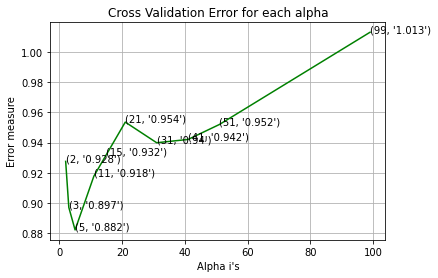

In [80]:
neighbour = [2, 3, 5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in neighbour:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_val, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(neighbour, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((neighbour[i],str(txt)), (neighbour[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



In [81]:
best_neigh = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=neighbour[best_neigh])
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', neighbour[best_neigh], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', neighbour[best_neigh], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', neighbour[best_neigh], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  5 The train log loss is: 0.47198098177168757
For values of best alpha =  5 The cross validation log loss is: 0.8820858268983708
For values of best alpha =  5 The test log loss is: 0.7543585652119406


### 4.2.2. Testing the model with best hyper paramters

Log loss : 0.8820858268983708
Number of mis-classified points : 0.26127819548872183


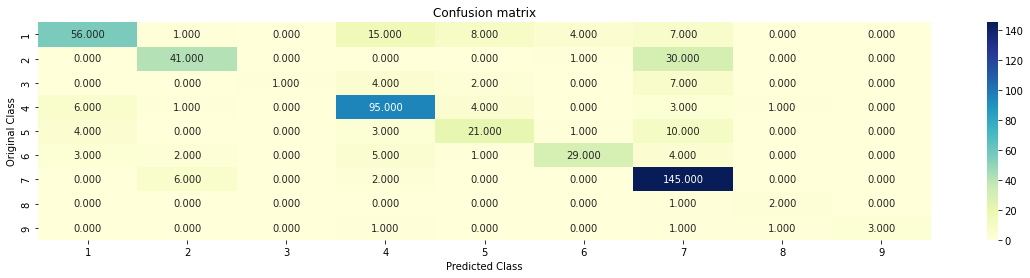

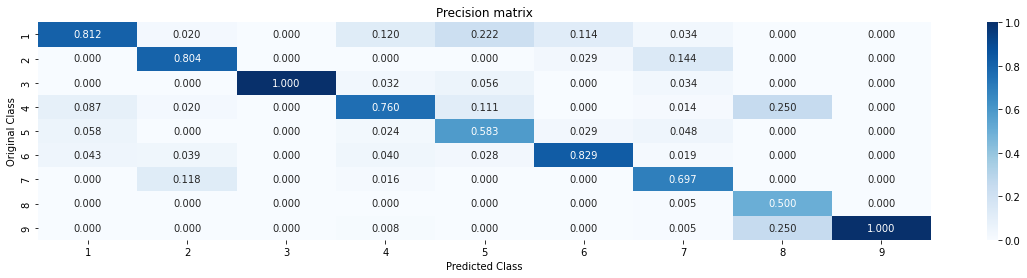

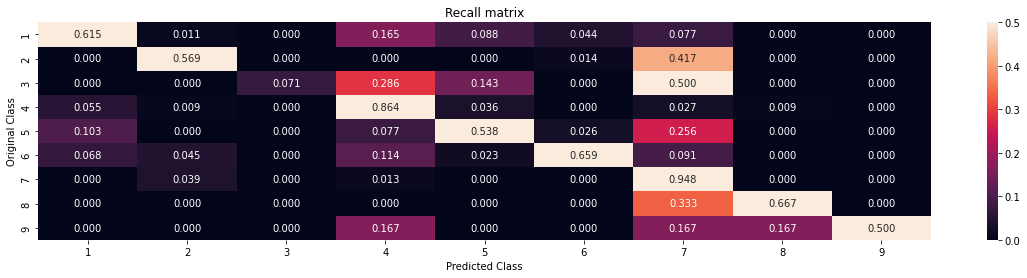

In [82]:
clf = KNeighborsClassifier(n_neighbors=neighbour[best_neigh])
predict_and_plot_confusion_matrix(train_x_responseCoding, y_train, cv_x_responseCoding, y_val, clf)

### 4.2.3.Sample Query point -1

In [83]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), neighbour[best_neigh])
print("The ",neighbour[best_neigh]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


In [84]:
clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), neighbour[best_neigh])

(array([[0.01423992, 0.01669373, 0.01746305, 0.0201741 , 0.02039516]]),
 array([[1915, 1675, 1104,  342,  912]]))

### 4.2.4. Sample Query Point-2

In [85]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), neighbour[best_neigh])
print("The ",neighbour[best_neigh]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


## 4.3. Logistic Regression

### 4.3.1. With Class balancing

for alpha = 1e-06
Log Loss : 1.3457043461312668
for alpha = 1e-05
Log Loss : 1.3130995803069974
for alpha = 0.0001
Log Loss : 1.1556297898630083
for alpha = 0.001
Log Loss : 1.1270193009133875
for alpha = 0.01
Log Loss : 1.162985017240738
for alpha = 0.1
Log Loss : 1.462468943594137
for alpha = 1
Log Loss : 1.7115260141376456
for alpha = 10
Log Loss : 1.73848502093665
for alpha = 100
Log Loss : 1.741245716702191


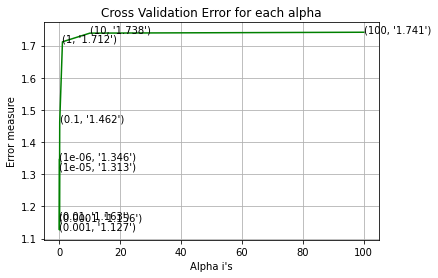

In [86]:
# 4.3.1.1. Hyper paramter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [87]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5378319941054021
For values of best alpha =  0.001 The cross validation log loss is: 1.1270193009133875
For values of best alpha =  0.001 The test log loss is: 0.9897030374176088


4.3.1.2. Testing the model with best hyper paramters

Log loss : 1.1270193009133875
Number of mis-classified points : 0.3233082706766917


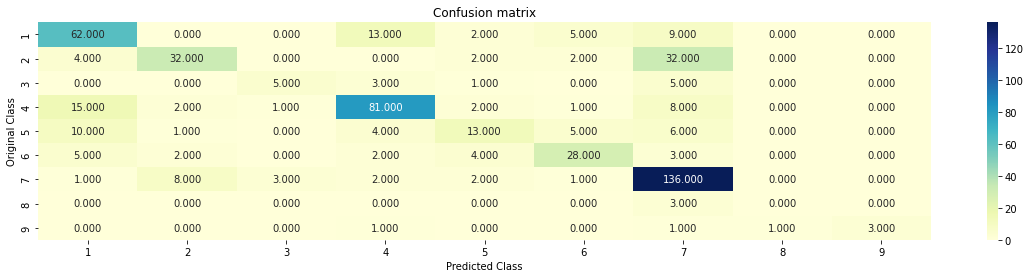

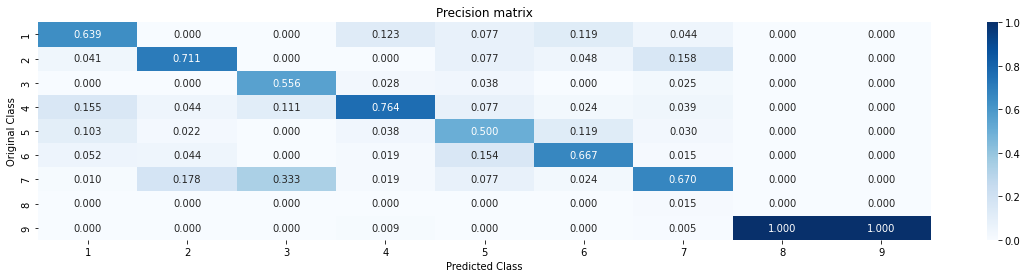

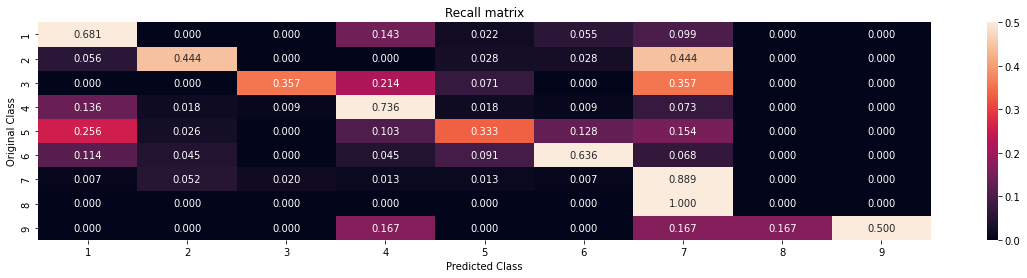

In [88]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_val, clf)

4.3.1.3. Feature Importance

In [89]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

### 4.3.1.3.1. Correctly Classified point

In [90]:
from tabulate import tabulate
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[3.000e-04 7.000e-03 1.000e-04 2.000e-04 1.000e-04 1.000e-04 9.862e-01
  5.200e-03 8.000e-04]]
Actual Class : 7
--------------------------------------------------
96 Text feature [3t3] present in test data point [True]
97 Text feature [constitutive] present in test data point [True]
99 Text feature [subcutaneously] present in test data point [True]
100 Text feature [nonsense] present in test data point [True]
101 Text feature [nude] present in test data point [True]
104 Text feature [oncogene] present in test data point [True]
112 Text feature [missense] present in test data point [True]
133 Text feature [transforming] present in test data point [True]
140 Text feature [q61e] present in test data point [True]
143 Text feature [activated] present in test data point [True]
158 Text feature [agar] present in test data point [True]
165 Text feature [mitogen] present in test data point [True]
168 Text feature [unstable] present in test dat

### 4.3.1.3.2. Incorrectly Classified point


In [91]:
from tabulate import tabulate
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[6.200e-03 1.100e-02 2.000e-04 2.500e-03 1.200e-03 1.100e-03 9.716e-01
  4.700e-03 1.600e-03]]
Actual Class : 7
--------------------------------------------------
97 Text feature [constitutive] present in test data point [True]
99 Text feature [subcutaneously] present in test data point [True]
104 Text feature [oncogene] present in test data point [True]
130 Text feature [infect] present in test data point [True]
133 Text feature [transforming] present in test data point [True]
143 Text feature [activated] present in test data point [True]
171 Text feature [constitutively] present in test data point [True]
178 Text feature [injection] present in test data point [True]
194 Text feature [soft] present in test data point [True]
202 Text feature [elicited] present in test data point [True]
248 Text feature [function] present in test data point [True]
275 Text feature [loss] present in test data point [True]
278 Text feature [activating] p

## 4.3.2. Without Class balancing

#### 4.3.2.1. Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3135952225534566
for alpha = 1e-05
Log Loss : 1.3194326571661685
for alpha = 0.0001
Log Loss : 1.1633217693740743
for alpha = 0.001
Log Loss : 1.1376053874510026
for alpha = 0.01
Log Loss : 1.2423310200713908
for alpha = 0.1
Log Loss : 1.3101774153370265
for alpha = 1
Log Loss : 1.5314374686889705
for alpha = 10
Log Loss : 1.5847711131869562
for alpha = 100
Log Loss : 1.5908645306030182


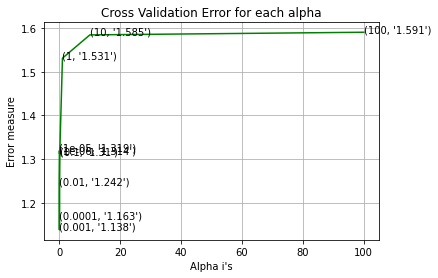

In [92]:


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [93]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.536228455007829
For values of best alpha =  0.001 The cross validation log loss is: 1.1376053874510026
For values of best alpha =  0.001 The test log loss is: 1.0054950584689095


### 4.3.2.2. Testing the model with best hyper paramters

Log loss : 1.1376053874510026
Number of mis-classified points : 0.3176691729323308


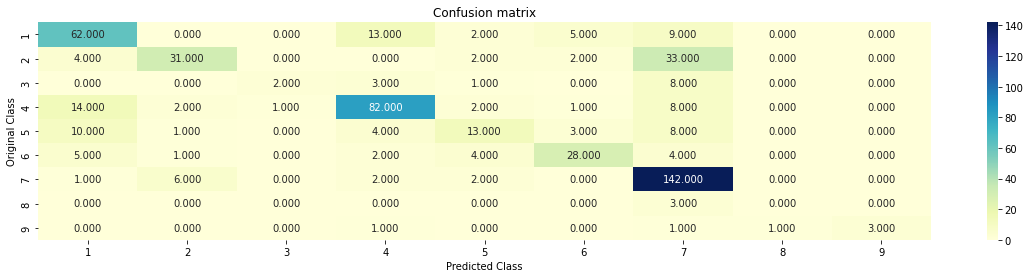

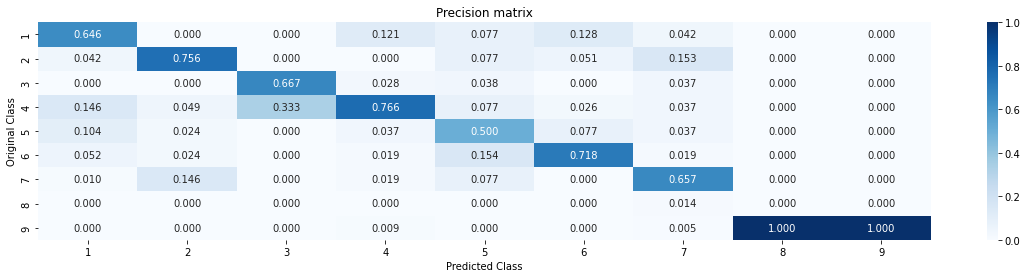

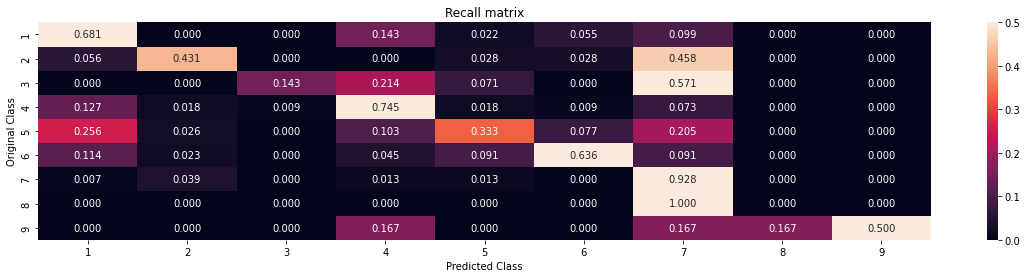

In [94]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_val, clf)

### 4.3.2.3. Feature Importance, Correctly Classified point

In [95]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[4.000e-04 8.400e-03 1.000e-04 3.000e-04 1.000e-04 1.000e-04 9.853e-01
  4.100e-03 1.200e-03]]
Actual Class : 7
--------------------------------------------------
166 Text feature [3t3] present in test data point [True]
174 Text feature [q61e] present in test data point [True]
180 Text feature [subcutaneously] present in test data point [True]
182 Text feature [constitutive] present in test data point [True]
188 Text feature [transforming] present in test data point [True]
200 Text feature [oncogene] present in test data point [True]
201 Text feature [nude] present in test data point [True]
255 Text feature [agar] present in test data point [True]
279 Text feature [activated] present in test data point [True]
286 Text feature [nonsense] present in test data point [True]
289 Text feature [constitutively] present in test data point [True]
291 Text feature [soft] present in test data point [True]
300 Text feature [mitogen] present in tes

### 4.3.2.4. Feature Importance, Inorrectly Classified point


In [96]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[6.900e-03 1.160e-02 2.000e-04 3.100e-03 1.000e-03 1.000e-03 9.701e-01
  4.200e-03 1.800e-03]]
Actual Class : 7
--------------------------------------------------
180 Text feature [subcutaneously] present in test data point [True]
182 Text feature [constitutive] present in test data point [True]
188 Text feature [transforming] present in test data point [True]
200 Text feature [oncogene] present in test data point [True]
263 Text feature [infect] present in test data point [True]
279 Text feature [activated] present in test data point [True]
289 Text feature [constitutively] present in test data point [True]
291 Text feature [soft] present in test data point [True]
311 Text feature [activating] present in test data point [True]
342 Text feature [injection] present in test data point [True]
431 Text feature [balb] present in test data point [True]
435 Text feature [transformation] present in test data point [True]
443 Text feature [exp

## 4.4. Linear Support Vector Machines

#### 4.4.1. Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3425946089992438
for alpha = 1e-05
Log Loss : 1.314675612551547
for alpha = 0.0001
Log Loss : 1.2661956188337977
for alpha = 0.001
Log Loss : 1.1521118692180972
for alpha = 0.01
Log Loss : 1.154128676295344
for alpha = 0.1
Log Loss : 1.4154035158091516
for alpha = 1
Log Loss : 1.7270728649996534
for alpha = 10
Log Loss : 1.7417331341556603
for alpha = 100
Log Loss : 1.7417431665041436


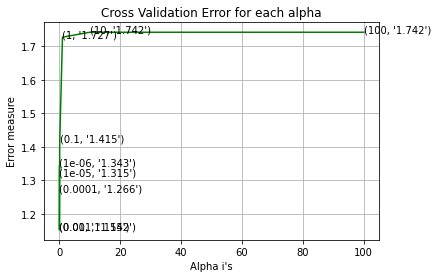

In [97]:
# 4.3.1.1. Hyper paramter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [98]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5465138166441659
For values of best alpha =  0.001 The cross validation log loss is: 1.1521118692180972
For values of best alpha =  0.001 The test log loss is: 1.0972922781953114


## 4.4.2. Testing the model with best hyper parameters

Log loss : 1.1521118692180972
Number of mis-classified points : 0.32706766917293234


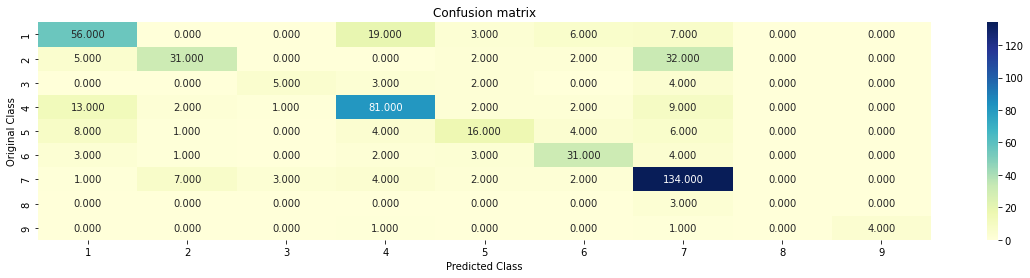

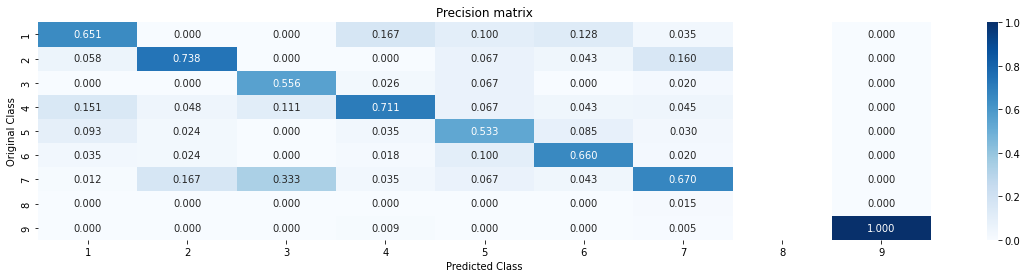

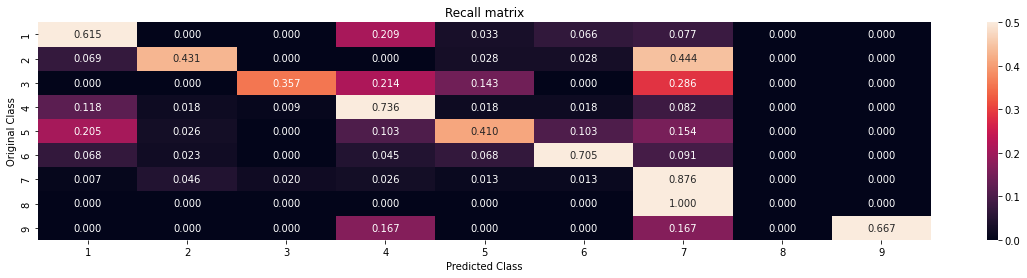

In [99]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_val, clf)

## 4.3.3. Feature Importance

### 4.3.3.1. For Correctly classified point

### 4.3.1.3.1. Correctly Classified point

In [100]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[9.800e-03 2.080e-02 1.000e-04 2.270e-02 2.000e-03 5.500e-03 9.282e-01
  6.900e-03 3.900e-03]]
Actual Class : 7
--------------------------------------------------
119 Text feature [q61e] present in test data point [True]
319 Text feature [agar] present in test data point [True]
345 Text feature [3t3] present in test data point [True]
376 Text feature [transforming] present in test data point [True]
390 Text feature [soft] present in test data point [True]
422 Text feature [nude] present in test data point [True]
450 Text feature [subcutaneously] present in test data point [True]
471 Text feature [noncanonical] present in test data point [True]
472 Text feature [oncogene] present in test data point [True]
476 Text feature [technology] present in test data point [True]
Out of the top  500  features  10 are present in query point


### 4.3.1.3.2. Incorrectly Classified point


In [101]:
from tabulate import tabulate
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0704 0.0204 0.0032 0.0351 0.0072 0.0069 0.8479 0.0057 0.0033]]
Actual Class : 7
--------------------------------------------------
76 Text feature [fev] present in test data point [True]
376 Text feature [transforming] present in test data point [True]
390 Text feature [soft] present in test data point [True]
442 Text feature [infect] present in test data point [True]
450 Text feature [subcutaneously] present in test data point [True]
472 Text feature [oncogene] present in test data point [True]
Out of the top  500  features  6 are present in query point


## 4.5 Random Forest Classifier

### 4.5.1. Hyper paramter tuning (With One hot Encoding)

In [102]:

alpha = [100,200,500,1000]
max_depth = [5, 10]
cv_log_error_array = []
for i in tqdm(alpha):
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_val, sig_clf_probs)) 


  0%|          | 0/4 [00:00<?, ?it/s]

for n_estimators = 100 and max depth =  5
Log Loss : 1.2597143151295294
for n_estimators = 100 and max depth =  10


 25%|██▌       | 1/4 [00:20<01:01, 20.56s/it]

Log Loss : 1.1794395984708423
for n_estimators = 200 and max depth =  5
Log Loss : 1.2519625695503407
for n_estimators = 200 and max depth =  10


 50%|█████     | 2/4 [00:53<00:55, 27.62s/it]

Log Loss : 1.1736689550923805
for n_estimators = 500 and max depth =  5
Log Loss : 1.2521193526929062
for n_estimators = 500 and max depth =  10


 75%|███████▌  | 3/4 [02:07<00:48, 48.93s/it]

Log Loss : 1.1747590891108257
for n_estimators = 1000 and max depth =  5
Log Loss : 1.250341544750166
for n_estimators = 1000 and max depth =  10


100%|██████████| 4/4 [04:28<00:00, 67.05s/it]

Log Loss : 1.1730908120924908


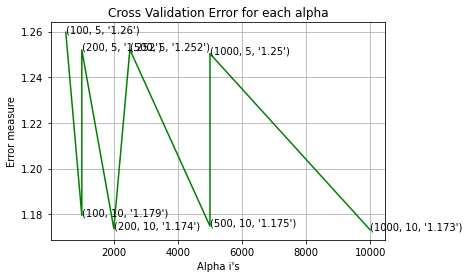

In [103]:
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [104]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best estimator =  1000 The train log loss is: 0.7103667929193804
For values of best estimator =  1000 The cross validation log loss is: 1.1730908120924906
For values of best estimator =  1000 The test log loss is: 1.1211897556195844


### 4.5.2. Testing model with best hyper parameters (One Hot Encoding)

Log loss : 1.1730908120924908
Number of mis-classified points : 0.38721804511278196


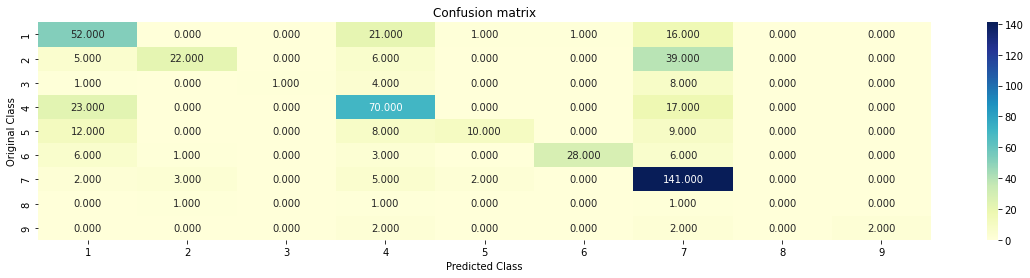

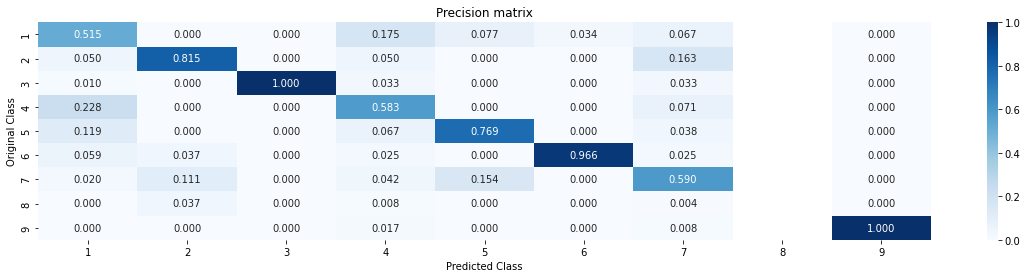

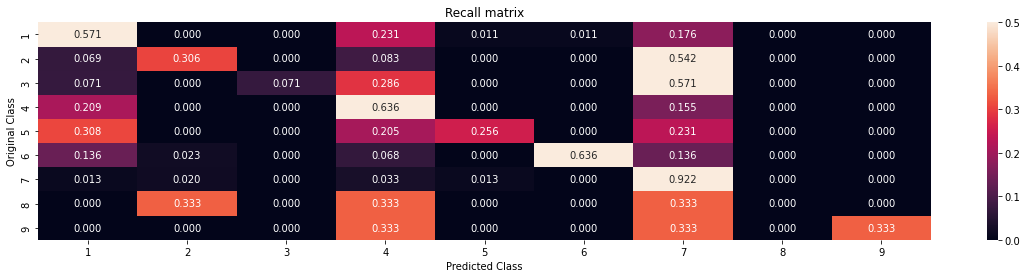

In [105]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train,cv_x_onehotCoding,y_val, clf)

### 4.5.3. Feature Importance

#### 4.5.3.1. Correctly Classified point

In [106]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0434 0.1216 0.0158 0.0479 0.0339 0.0325 0.6934 0.005  0.0065]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [missense] present in test data point [True]
3 Text feature [phosphorylation] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [treatment] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
7 Text feature [function] present in test data point [True]
8 Text feature [oncogenic] present in test data point [True]
9 Text feature [tyrosine] present in test data point [True]
10 Text feature [inhibitor] present in test data point [True]
11 Text feature [constitutive] present in test data point [True]
12 Text feature [suppressor] present in test data point [True]
14 Text fea

#### 4.5.3.2. Inorrectly Classified point

In [107]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0963 0.1003 0.0195 0.0776 0.0434 0.0401 0.6027 0.0069 0.0133]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [treatment] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
7 Text feature [function] present in test data point [True]
8 Text feature [oncogenic] present in test data point [True]
9 Text feature [tyrosine] present in test data point [True]
10 Text feature [inhibitor] present in test data point [True]
11 Text feature [constitutive] present in test data point [True]
12 Text feature [suppressor] present in test data point [True]
14 Text feature [activated] present in test data point [True]
15 Text feature [months] present in test data point [True]
18 Text feature [

## 4.5.4. Hyper paramter tuning (With Response Coding)

In [108]:
alpha = [100,200,500,1000]
max_depth = [5, 10, 15]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_val, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 0.09208618346264057
for n_estimators = 100 and max depth =  10
Log Loss : 0.07213045891722906
for n_estimators = 100 and max depth =  15
Log Loss : 0.07155757852290186
for n_estimators = 200 and max depth =  5
Log Loss : 0.09040166081372975
for n_estimators = 200 and max depth =  10
Log Loss : 0.07245525700994236
for n_estimators = 200 and max depth =  15
Log Loss : 0.07170506070563565
for n_estimators = 500 and max depth =  5
Log Loss : 0.08791972836335647
for n_estimators = 500 and max depth =  10
Log Loss : 0.07238377984507767
for n_estimators = 500 and max depth =  15
Log Loss : 0.07121962864794587
for n_estimators = 1000 and max depth =  5
Log Loss : 0.08802504743402509
for n_estimators = 1000 and max depth =  10
Log Loss : 0.07193073223396006
for n_estimators = 1000 and max depth =  15
Log Loss : 0.07113541611718516


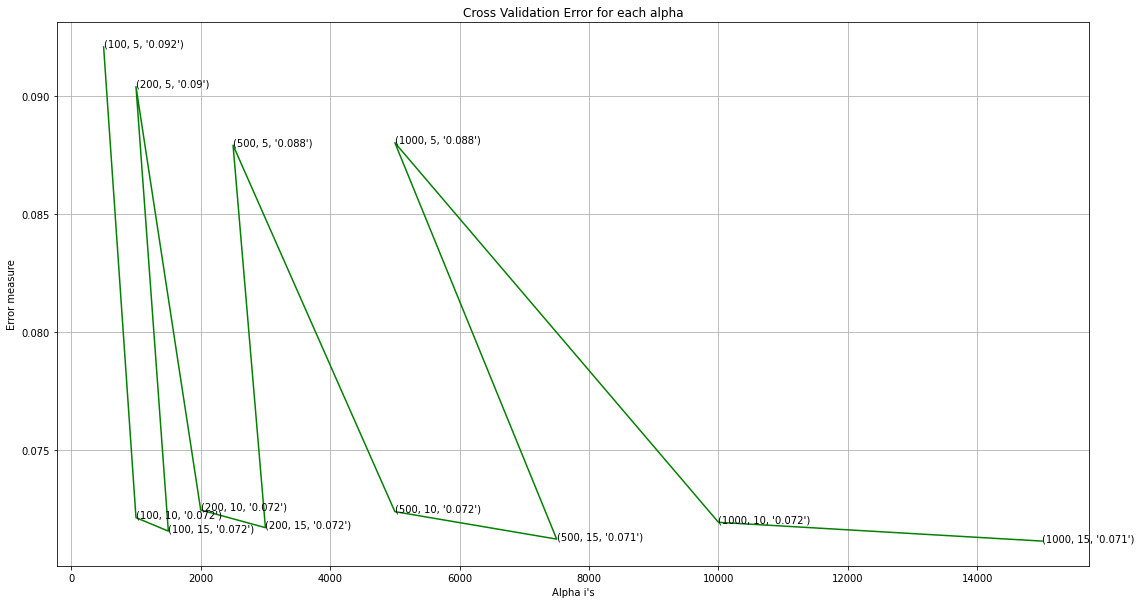

In [109]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10)
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/3)],max_depth[int(i%3)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [110]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/3)], criterion='gini', max_depth=max_depth[int(best_alpha%3)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1000 The train log loss is: 0.034764090632054406
For values of best alpha =  1000 The cross validation log loss is: 0.07113541611718516
For values of best alpha =  1000 The test log loss is: 0.06744737393848682


### 4.5.4.2. Testing model with best hyper parameters (Response Coding)

In [111]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, y_train,cv_x_responseCoding,y_val, clf)

IndexError: list index out of range

### 4.5.5. Feature Importance

#### 4.5.5.1. Correctly Classified point

In [ ]:
test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")



#### 4.5.3.2. Inorrectly Classified point

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)


#for i in indices:
#    if i<9:
#        print("Gene is important feature")
#    elif i<18:
#        print("Variation is important feature")
#    else:
#        print("Text is important feature")

## 4.7 Stack the models

### 4.7.1 testing with hyper parameter tuning

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_val, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_val, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_val, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))


In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, y_train)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=sclf.predict(test_x_onehotCoding))

### 4.7.3 Maximum Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_val, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=vclf.predict(test_x_onehotCoding))

In [ ]:
np.save("X_train.npy",X_train)
np.save("X_val.npy", X_val)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save('y_val.npy', y_val)
np.save("y_test.npy", y_test)

In [ ]:
np.save('train_x_onehotCoding.npy',train_x_onehotCoding)
np.save("train_x_responseCoding.npy",train_x_responseCoding)

np.save("test_x_onehotCoding.npy",test_x_onehotCoding)
np.save("test_x_responseCoding.npy", test_x_responseCoding)

np.save("cv_x_onehotCoding.npy",cv_x_onehotCoding)
np.save("cv_x_responseCoding.npy", cv_x_responseCoding)